In [1]:
import os
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_columns', 300)
plt.rcParams["figure.figsize"]=16,6

# LGB Starter

Robado de https://www.kaggle.com/swimmy/optiver-lgb-with-optimized-params-feat

In [31]:
# data directory
data_dir = 'data/'

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Calculate the realized volatility considering the time intervals
def realized_volatility_with_intervals(series, intervals):
    return np.sqrt(np.sum( (series*intervals)**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv(data_dir + 'train.csv')
    test = pd.read_csv(data_dir + 'test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.mean, np.std],
        'wap2': [np.sum, np.mean, np.std],
        'log_return1': [np.sum, realized_volatility, np.mean, np.std],
        'log_return2': [np.sum, realized_volatility, np.mean, np.std],
        'wap_balance': [np.sum, np.mean, np.std],
        'price_spread':[np.sum, np.mean, np.std],
        'price_spread2':[np.sum, np.mean, np.std],
        'bid_spread':[np.sum, np.mean, np.std],
        'ask_spread':[np.sum, np.mean, np.std],
        'total_volume':[np.sum, np.mean, np.std],
        'volume_imbalance':[np.sum, np.mean, np.std],
        "bid_ask_spread":[np.sum, np.mean, np.std],
    }
    
    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature
    
    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    
    # Create row_id so we can merge
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }

    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(create_feature_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature

    # Get the stats for different windows
    df_feature = get_stats_window(seconds_in_bucket = 0, add_suffix = False)
    df_feature_450 = get_stats_window(seconds_in_bucket = 450, add_suffix = True)
#     df_feature_500 = get_stats_window(seconds_in_bucket = 500, add_suffix = True)
#     df_feature_400 = get_stats_window(seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(seconds_in_bucket = 300, add_suffix = True)
#     df_feature_200 = get_stats_window(seconds_in_bucket = 200, add_suffix = True)
    df_feature_150 = get_stats_window(seconds_in_bucket = 150, add_suffix = True)

    # Merge all
    df_feature = df_feature.merge(df_feature_450, how = 'left', left_on = 'time_id_', right_on = 'time_id__450')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
#     df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_150, how = 'left', left_on = 'time_id_', right_on = 'time_id__150')
#     df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    df_feature.drop(['time_id__450', 'time_id__300', 'time_id__150'], axis = 1, inplace = True)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']
#     vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility',
#                 'log_return1_realized_volatility_600', 'log_return2_realized_volatility_600', 
#                 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
# #                 'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 
#                 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200',
# #                 'log_return1_realized_volatility_100', 'log_return2_realized_volatility_100', 
#                 'trade_log_return_realized_volatility',
#                 'trade_log_return_realized_volatility_600', 
#                 'trade_log_return_realized_volatility_400',
# #                 'trade_log_return_realized_volatility_300',
# #                 'trade_log_return_realized_volatility_100',
#                 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

# Funtion to make preprocessing function in parallel (for each stock id)
def preprocessor(list_stock_ids, is_train = True):
    
    # Parrallel for loop
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        # Test
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
    
        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')
        
        # Return the merge dataframe
        return df_tmp

    # Use parallel api to call paralle for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

# Function to early stop with root mean squared percentage error
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

def train_and_evaluate(train, test):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 1000,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 5,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    x_test = test.drop(['row_id', 'time_id'], axis = 1)
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    x_test['stock_id'] = x_test['stock_id'].astype(int)
    
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    # Create a KFold object
    kfold = KFold(n_splits = 20, random_state = 1111, shuffle = True)
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 6000, 
                          early_stopping_rounds = 300, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        plt.figure(figsize=(12,6))
        lgb.plot_importance(model, max_num_features=10)
        plt.title("Feature importance")
        plt.show()
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        test_predictions += model.predict(x_test) / 20
        
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return test_predictions

# Read train and test
train, test = read_train_test()

# Get unique stock ids 
train_stock_ids = train['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids 
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
test = get_time_stock(test)

# Traing and evaluate
#test_predictions = train_and_evaluate(train, test)
# Save test predictions
test['target'] = test_predictions
test[['row_id', 'target']].to_csv('submission.csv',index = False)

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   44.3s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


NameError: name 'test_predictions' is not defined

# Tratando de entender los datos

In [32]:
train_

,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,row_id,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150
0,303.125061,1.003725,0.000693,303.105539,1.003661,0.000781,0.002292,0.004499,7.613599e-06,0.000260,0.002325,0.006999,0.000008,0.000404,0.117051,0.000388,0.000295,0.257255,0.000852,0.000211,0.355451,0.001177,0.000213,0.053006,0.000176,0.000162,-0.045557,-0.000151,0.000126,97696,323.496689,138.101214,40738,134.894040,107.260583,0.098563,0.000326,0.000222,68.236749,1.003482,0.000514,68.231672,1.003407,0.000640,-0.000361,0.001721,-0.000005,0.000210,0.000068,0.004114,0.000001,0.0

In [33]:
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_vola

In [322]:
pd.read_csv(data_dir + 'train.csv').head(20)

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
5,0,72,0.004912
6,0,97,0.009388
7,0,103,0.004120
8,0,109,0.002182
9,0,123,0.002669


In [539]:
book_example = pd.read_parquet(data_dir + 'book_train.parquet/stock_id=0')
trade_example =  pd.read_parquet(data_dir + 'trade_train.parquet/stock_id=0')
stock_id = '0'
book_example = book_example[book_example['time_id']==11]
trade_example = trade_example[trade_example['time_id']==11]

In [540]:
book_example['wap'] = (book_example['bid_price1'] * book_example['ask_size1'] +
                                book_example['ask_price1'] * book_example['bid_size1']) / (
                                       book_example['bid_size1']+ book_example['ask_size1'])

In [541]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap
302,11,0,0.999473,1.000176,0.999423,1.000376,205,100,20,30,0.999945
303,11,3,0.999473,1.000176,0.999423,1.000376,200,100,20,30,0.999941
304,11,13,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042
305,11,18,0.999473,1.000025,0.999423,1.000376,200,100,20,30,0.999841
306,11,28,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042
...,...,...,...,...,...,...,...,...,...,...,...
497,11,570,1.000025,1.000778,0.999975,1.000878,309,10,120,44,1.000754
498,11,574,1.000025,1.000778,0.999975,1.000878,200,10,120,44,1.000742
499,11,584,1.000276,1.000778,0.999975,1.000878,1,32,120,84,1.000291
500,11,585,1.000276,1.000778,0.999975,1.000878,1,32,120,44,1.000291


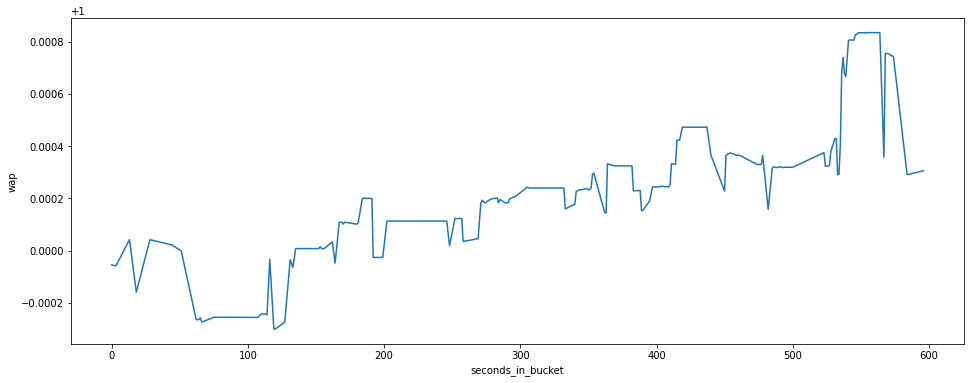

In [542]:
sns.lineplot(data=book_example, x="seconds_in_bucket", y="wap");

In [543]:
book_example.loc[:,'log_return'] = log_return(book_example['wap'])
#book_example.loc[:,'log_return'] = log_return(book_example['wap']).diff()
book_example.loc[:,'time_diff'] = book_example['seconds_in_bucket'].diff()
book_example = book_example[~book_example['log_return'].isnull()]

In [544]:
book_example

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return,time_diff
303,11,3,0.999473,1.000176,0.999423,1.000376,200,100,20,30,0.999941,-0.000004,3.0
304,11,13,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042,0.000100,10.0
305,11,18,0.999473,1.000025,0.999423,1.000376,200,100,20,30,0.999841,-0.000201,5.0
306,11,28,0.999473,1.000326,0.999423,1.000376,200,100,20,30,1.000042,0.000201,10.0
307,11,44,0.999473,1.000326,0.999423,1.000376,200,111,20,30,1.000022,-0.000020,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,11,570,1.000025,1.000778,0.999975,1.000878,309,10,120,44,1.000754,0.000000,2.0
498,11,574,1.000025,1.000778,0.999975,1.000878,200,10,120,44,1.000742,-0.000012,4.0
499,11,584,1.000276,1.000778,0.999975,1.000878,1,32,120,84,1.000291,-0.000451,10.0
500,11,585,1.000276,1.000778,0.999975,1.000878,1,32,120,44,1.000291,0.000000,1.0


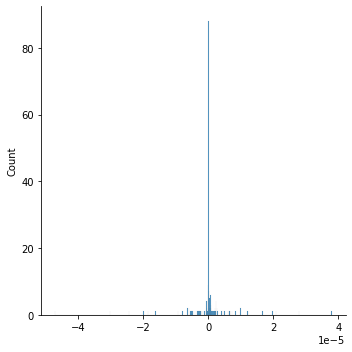

In [545]:
sns.displot(data=book_example.log_return / np.sqrt(book_example.seconds_in_bucket));

In [546]:
distr = book_example.log_return / np.sqrt(book_example.seconds_in_bucket)

In [547]:
book_example.describe()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,wap,log_return,time_diff
count,199.0,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,1.990000e+02,199.000000
mean,11.0,334.261307,1.000014,1.000407,0.999872,1.000541,149.688442,71.000000,95.824121,95.221106,1.000240,1.810239e-06,2.994975
std,0.0,155.144905,0.000282,0.000219,0.000243,0.000217,124.720469,98.671376,92.080741,88.847795,0.000262,8.557596e-05,3.834318
min,11.0,3.000000,0.999473,0.999975,0.999423,1.000176,1.000000,1.000000,1.000000,1.000000,0.999700,-4.760970e-04,1.000000
25%,11.0,208.000000,0.999724,1.000326,0.999674,1.000376,18.500000,10.000000,20.000000,22.000000,1.000113,-4.683028e-07,1.000000
50%,11.0,352.000000,1.000025,1.000376,0.999975,1.000527,138.000000,27.000000,72.000000,100.000000,1.000233,0.000000e+00,2.000000
75%,11.0,460.000000,1.000126,1.000527,1.000025,1.000678,260.000000,100.000000,141.500000,125.000000,1.000328,6.402142e-06,3.000000
max,11.0,596.000000,1.000627,1.000878,1.000477,1.001179,402.000000,400.000000,360.000000,378.000000,1.000834,3.963518e-04,29.000000


In [548]:
book_example.log_return.values.std() * np.sqrt(book_example.shape[0])

0.001204160514363813

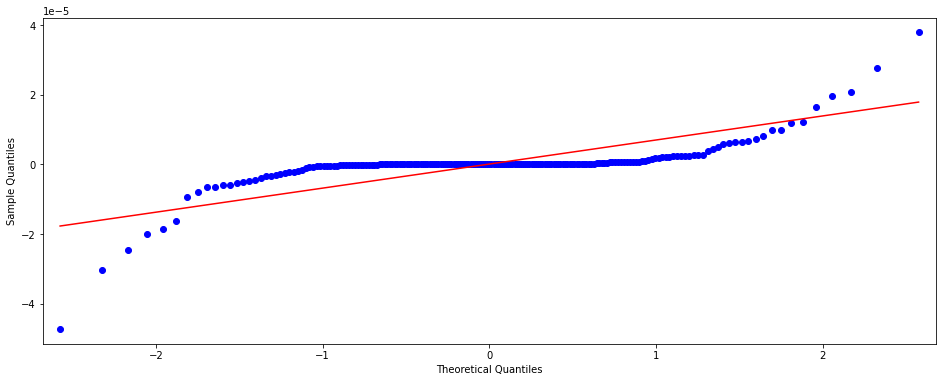

In [549]:
from statsmodels.graphics.gofplots import qqplot

# q-q plot
qqplot(distr, line='s')
plt.show()

In [550]:
from scipy.stats import shapiro

stat, p = shapiro(distr)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.572, p=0.000
Sample does not look Gaussian (reject H0)


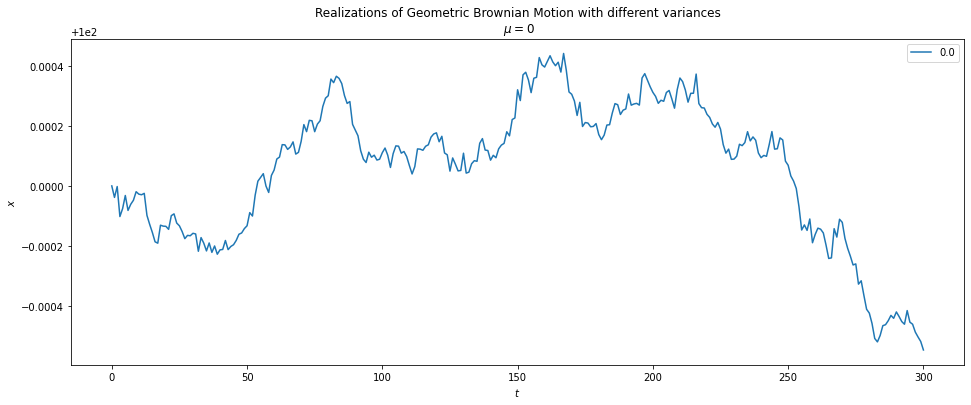

In [551]:
mu = 0
n = 300
dt = 0.00001
x0 = 100

sigma = np.arange(0.0001, 0.00011, 0.00001)

x = np.exp( (mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(len(sigma), n)).T)
x = np.vstack([np.ones(len(sigma)), x])
x = x0 * x.cumprod(axis=0)

plt.plot(x)
plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=0$"
)
plt.show()

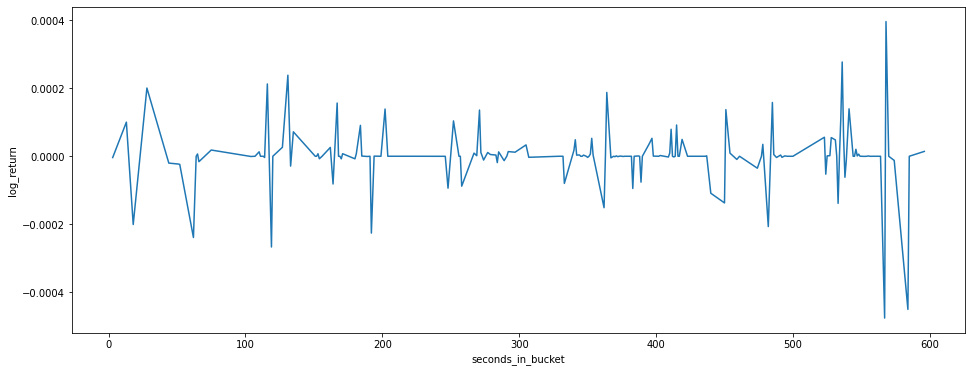

In [552]:
sns.lineplot(data=book_example, x="seconds_in_bucket", y="log_return");

In [553]:
realized_vol = realized_volatility(book_example['log_return'])
realized_vol_intervals = realized_volatility_with_intervals(book_example['log_return'], book_example['time_diff'])
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol}')
print(f'Realized volatility for stock_id 0 on time_id 5 is {realized_vol_intervals}')

Realized volatility for stock_id 0 on time_id 5 is 0.0012044312600105803
Realized volatility for stock_id 0 on time_id 5 is 0.006619260491094164


In [554]:
trade_example

,time_id,seconds_in_bucket,price,size,order_count
40,11,0,0.999824,2,2
41,11,18,0.999925,1,1
42,11,28,0.999925,1,1
43,11,64,0.999724,1,1
44,11,75,1.000025,110,2
45,11,131,0.999925,1,1
46,11,164,0.999990,29,3
47,11,184,0.999875,20,1
48,11,202,0.999975,2,2
49,11,246,0.999724,3,1


In [555]:
test

,stock_id,time_id,row_id,wap1_sum,wap1_mean,wap1_std,wap2_sum,wap2_mean,wap2_std,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,wap_balance_sum,wap_balance_mean,wap_balance_std,price_spread_sum,price_spread_mean,price_spread_std,price_spread2_sum,price_spread2_mean,price_spread2_std,bid_spread_sum,bid_spread_mean,bid_spread_std,ask_spread_sum,ask_spread_mean,ask_spread_std,total_volume_sum,total_volume_mean,total_volume_std,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,bid_ask_spread_sum,bid_ask_spread_mean,bid_ask_spread_std,wap1_sum_450,wap1_mean_450,wap1_std_450,wap2_sum_450,wap2_mean_450,wap2_std_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread2_sum_450,price_spread2_mean_450,price_spread2_std_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,bid_ask_spread_sum_450,bid_ask_spread_mean_450,bid_ask_spread_std_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap2_sum_300,wap2_mean_300,wap2_std_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread2_sum_300,price_spread2_mean_300,price_spread2_std_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,bid_ask_spread_sum_300,bid_ask_spread_mean_300,bid_ask_spread_std_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap2_sum_150,wap2_mean_150,wap2_std_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,wap_balance_sum_150,wap_balance_mean_150,wap_balance_std_150,price_spread_sum_150,price_spread_mean_150,price_spread_std_150,price_spread2_sum_150,price_spread2_mean_150,price_spread2_std_150,bid_spread_sum_150,bid_spread_mean_150,bid_spread_std_150,ask_spread_sum_150,ask_spread_mean_150,ask_spread_std_150,total_volume_sum_150,total_volume_mean_150,total_volume_std_150,volume_imbalance_sum_150,volume_imbalance_mean_150,volume_imbalance_std_150,bid_ask_spread_sum_150,bid_ask_spread_mean_150,bid_ask_spread_std_150,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_sum_150,trade_order_count_mean_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_450_mean_stock,log_return1_realized_volatility_450_std_stock,log_return1_realized_volatility_

# Estimando volatilidad siguiendo un movimiento browniano 

Robado de https://www.kaggle.com/pcarta/jane-street-time-horizons-and-volatilities#Understanding-the-Resps-times,-and-getting-volatilities-for-free

In [556]:
import torch
device = torch.device('cuda')

# initialize parameters

# initialize the sigmas randomly
sigma = torch.tensor(np.random.randn()*.01 + 1, device=device, dtype=torch.float)
gamma = torch.tensor(np.random.randn()*.01 + 500, device=device, dtype=torch.float)

# the actual parameters are the logarithms of the delta T and sigma, to enforce positivity and have
# more stable convergence
with torch.no_grad():
    sigma_log = torch.log(sigma).clone().requires_grad_(True)
    gamma_log = torch.log(gamma).clone().requires_grad_(True)

# load the data to gpu (increments)
dW = torch.tensor(book_example.log_return.values, device=device)
dT = torch.tensor(book_example.time_diff.values, device=device)

In [557]:
ITERS = 20000

# use Adam as it finds the right learning rates easily
opt = torch.optim.Adam([sigma_log])

iteration = 0
while iteration < ITERS:
    # reset the gradients to 0
    opt.zero_grad()

    # compute the log-likelihood (divided by number of rows)
    logL = torch.sum(1/2 *(dW**2  @ (1/dT)) * (1/torch.exp(2*sigma_log))) + 1/2*torch.sum(torch.log(dT)) + 4*sigma_log
    #logL = torch.sum(1/2 *(dW**2  @ (torch.exp(gamma_log)/dT)) * (1/torch.exp(2*sigma_log))) + gamma_log/2*torch.sum(torch.log(dT)) + 4*sigma_log
   
    # compute the gradient
    logL.backward()

    if iteration % 1000 == 0:
        with torch.no_grad():
            #print(f'iter {iteration:8} {logL:.15} sigma_log.grad.norm {torch.norm(sigma_log.grad):.9} sigma_log {torch.squeeze(sigma_log,0):.9} gamma_log.grad.norm {torch.norm(gamma_log.grad):.9} gamma_log {torch.squeeze(gamma_log,0):.9}')
            print(f'iter {iteration:8} {logL:.15} sigma_log.grad.norm {torch.norm(sigma_log.grad):.9} sigma {torch.squeeze(torch.exp(sigma_log),0):.9}')

    # execute one step of gradient descent
    opt.step()
    
    iteration+=1

iter        0 67.680879653932 sigma_log.grad.norm 3.99999928 sigma 1.01005173
iter     1000 63.6809185268541 sigma_log.grad.norm 3.99999499 sigma 0.37158069
iter     2000 59.6807500644765 sigma_log.grad.norm 3.99996281 sigma 0.136690587
iter     3000 55.6811544373551 sigma_log.grad.norm 3.99972534 sigma 0.0502892472
iter     4000 51.6825885515932 sigma_log.grad.norm 3.99797106 sigma 0.0185029563
iter     5000 47.6933400466994 sigma_log.grad.norm 3.98503971 sigma 0.00681415433
iter     6000 43.7711125688751 sigma_log.grad.norm 3.89114761 sigma 0.00252618105
iter     7000 40.2968180733731 sigma_log.grad.norm 3.27940726 sigma 0.000981834484
iter     8000 38.6159324158579 sigma_log.grad.norm 1.17157793 sigma 0.00049557694
iter     9000 38.5086848680676 sigma_log.grad.norm 0.0425746441 sigma 0.000418964162
iter    10000 38.5085705834895 sigma_log.grad.norm 0.000242948532 sigma 0.000416741124
iter    11000 38.508570651122 sigma_log.grad.norm 0.000154972076 sigma 0.000416736526
iter    12000 

In [558]:
# let's bring stuff to CPU memory
sigma = torch.exp(sigma_log).detach().cpu().numpy()

In [559]:
sigma

array(0.00041673, dtype=float32)

In [568]:
s = []
for dt in book_example.time_diff.values:
    s.append(np.random.normal(0, np.sqrt(dt)))
s = np.array(s)
print(np.sqrt(np.sum(s**2)))

24.849306852770354


In [570]:
0.00041673*25

0.010418249999999999